In [ ]:
!curl -X GET "https://datasets-server.huggingface.co/first-rows?dataset=amazon_us_reviews&config=Home_Entertainment_v1_00&split=train"

{"error":"Cannot load the dataset split (in streaming mode) to extract the first rows.","cause_exception":"FileNotFoundError","cause_message":"https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Home_Entertainment_v1_00.tsv.gz","cause_traceback":["Traceback (most recent call last):\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/fsspec/implementations/http.py\", line 417, in _info\n    await _file_info(\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/fsspec/implementations/http.py\", line 837, in _file_info\n    r.raise_for_status()\n","  File \"/src/services/worker/.venv/lib/python3.9/site-packages/aiohttp/client_reqrep.py\", line 1005, in raise_for_status\n    raise ClientResponseError(\n","aiohttp.client_exceptions.ClientResponseError: 403, message='Forbidden', url=URL('https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Home_Entertainment_v1_00.tsv.gz')\n","\nThe above exception was the direct cause of the followin

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tarfile

# Path to the .tgz file
tgz_file_path =  "/content/drive/MyDrive/code_files/Sri/Amazon_product_review/amazon_review_full_csv.tgz"

# Destination directory to extract the contents
extract_dest = '/content/'

# Open and extract the .tgz file
with tarfile.open(tgz_file_path, 'r:gz') as tar:
    tar.extractall(path=extract_dest)

print("Extraction complete.")

Extraction complete.


In [4]:

#General Imports
import numpy as np
import pandas as pd
import pickle
from os.path import join

#Preprocessing related imports
from nltk.stem import WordNetLemmatizer
import gensim.parsing.preprocessing as gpp
import gensim.utils as gu

In [5]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
#Load full dataset
data_dir = "/content/amazon_review_full_csv/"
data = pd.read_csv(join(data_dir, "train.csv"), header=None, names=['Rating', 'Title', 'Review'])
display(data)

,Rating,Title,Review
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...
...,...,...,...
2999995,1,Don't do it!!,The high chair looks great when it first comes...
2999996,2,"Looks nice, low functionality",I have used this highchair for 2 kids now and ...
2999997,2,"compact, but hard to clean","We have a small house, and really wanted two o..."
2999998,3,Hard to clean!,I agree with everyone else who says this chair...


In [13]:
data_sample1 = data.groupby("Rating").sample(500)
display(data_sample1)

,Rating,Title,Review
299826,1,Very Disappointing,The individual DVD holders in the box set came...
504992,1,At least get the examples right,"On average, there are 5 errors per chapter in ..."
453436,1,"Horrible book, horrible company",This company has a new revenue stream where th...
1757218,1,Broken out of the box,Bought one of these a week ago at Meijer. Open...
2051278,1,You will NOT get what's pictured in the produc...,I have a Wusthof Classic that's been sharpened...
...,...,...,...
2527167,5,A great tool for the price,After using a multi wire stripper tool for yea...
1155897,5,Awesome,"Awesome CD, was good from the beginning to the..."
743262,5,Fantastic book for little girls who love princ...,Our Granddaughter Aubrey Elizabeth is three an...
2602599,5,I WILL NEVER SEE THE WOODS THE SAME AGAIN,After reading this book I will never view the ...


In [14]:
data_sample1 = data_sample1.drop('Title', axis=1)
data_sample1.to_csv( "Sampled_data_final.csv", index=False)

In [15]:
# Check distribution of rating values as this is likely our target variable
data_sample1["Rating"].value_counts()

1    500
2    500
3    500
4    500
5    500
Name: Rating, dtype: int64

In [16]:
data_sample1.head()

,Rating,Review
299826,1,The individual DVD holders in the box set came...
504992,1,"On average, there are 5 errors per chapter in ..."
453436,1,This company has a new revenue stream where th...
1757218,1,Bought one of these a week ago at Meijer. Open...
2051278,1,I have a Wusthof Classic that's been sharpened...


In [ ]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim.parsing.preprocessing as gpp
import gensim.utils as gu

# Define the preprocess_and_lemmatize function
def preprocess_and_lemmatize(input_text):
    if isinstance(input_text, str):  # Handle NaN values
        preprocessing_steps = [
            gpp.strip_tags,
            gpp.strip_punctuation,
            gpp.strip_multiple_whitespaces,
            gpp.strip_numeric,
            gpp.remove_stopwords,
            gpp.strip_short,
        ]

        lemmatizer = WordNetLemmatizer()

        cleaned_text = gu.to_unicode(input_text.lower().strip())

        for preprocess_step in preprocessing_steps:
            cleaned_text = preprocess_step(cleaned_text)

        lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in cleaned_text.split()])

        return lemmatized_text
    else:
        return input_text  # Return as is for non-string values




In [ ]:

# Create the ReviewFull data column
data["FullReview"] = data["Title"] + " " + data["Review"]
data = data.drop(["Title", "Review"], axis=1)

# Apply preprocessing and lemmatization to the textual data
data["FullReview"] = data["FullReview"].apply(preprocess_and_lemmatize)
data.head()

,Rating,FullReview
0,3,like funchuck gave dad gag gift directing nuns...
1,5,inspiring hope lot people hear need strong pos...
2,5,best soundtrack reading lot review saying best...
3,4,chrono cross ost music yasunori misuda questio...
4,5,good true probably greatest soundtrack history...


In [ ]:
data.to_csv(join(data_dir, "preprocessed_data.csv"))

As the data is too large so it would be ideal to downsample the data to fewwer rows to do further analysis

In [ ]:
data_sample = data.groupby("Rating").sample(500)
display(data_sample)

,Rating,FullReview
53507,1,piece garbage year purchase awful product over...
711421,1,replacement ink cartridge bought fly pentop da...
1599049,1,amazon need remove selection plot acting minut...
1143160,1,called breaking child heart start good idea mi...
2287887,1,written offensive actually agree reviewer writ...
...,...,...
2221201,5,bos fan diana enjoy package video wish release...
1344362,5,workhorse personal small business printer boug...
2469700,5,good beautiful earphone excellent music qualit...
1260117,5,great transaction shipment quick communication...


In [ ]:
del(data)

In [ ]:
data_sample.Rating.value_counts()

1    2500
2    2500
3    2500
4    2500
5    2500
Name: Rating, dtype: int64

In [ ]:
data_sample.to_csv(join(data_dir, "Sampled_data.csv"))

In [ ]:
import pandas as pd
data_sample = pd.read_csv("/content/amazon_review_full_csv/Sampled_data.csv")

In [ ]:
data_org = data_sample.copy()

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords as nltk_stopwords

def generate_word_cloud(input_data, cloud_title):
    custom_stopwords = set(nltk_stopwords.words("english"))
    wordcloud = WordCloud(
        background_color="black",
        max_font_size=40,
        max_words=200,
        stopwords=custom_stopwords,
        scale=3
    ).generate(str(input_data))

    fig = plt.figure(figsize=(8, 8))
    plt.axis("off")

    if cloud_title:
        fig.suptitle(cloud_title, fontsize=16)
        fig.subplots_adjust(top=2.25)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()


In [ ]:
# # Grouping records into distinct variables for generating category-based word clouds
rating_1=data_sample[data_sample["Rating"] == 1]["FullReview"]
rating_2=data_sample[data_sample["Rating"] == 2]["FullReview"]
rating_3=data_sample[data_sample["Rating"] == 3]["FullReview"]
rating_4=data_sample[data_sample["Rating"] == 4]["FullReview"]
rating_5=data_sample[data_sample["Rating"] == 5]["FullReview"]

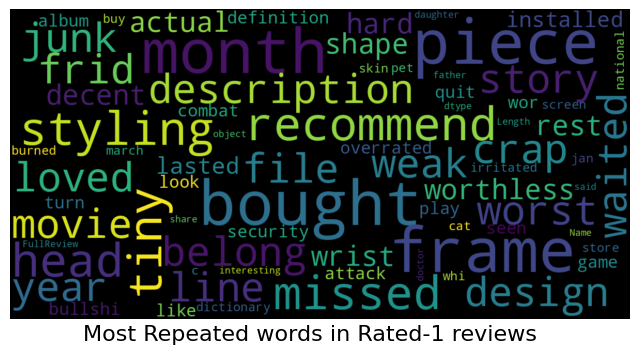

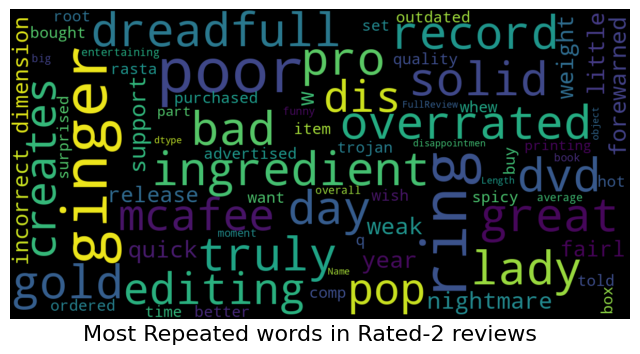

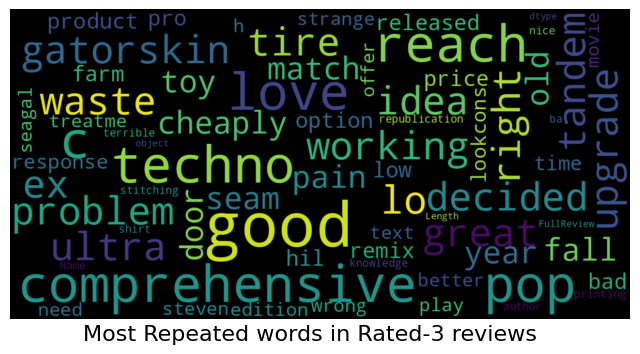

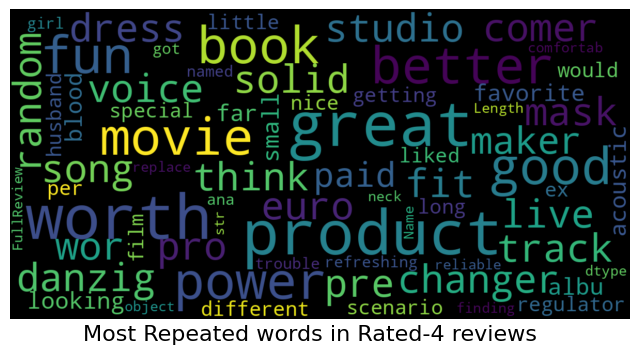

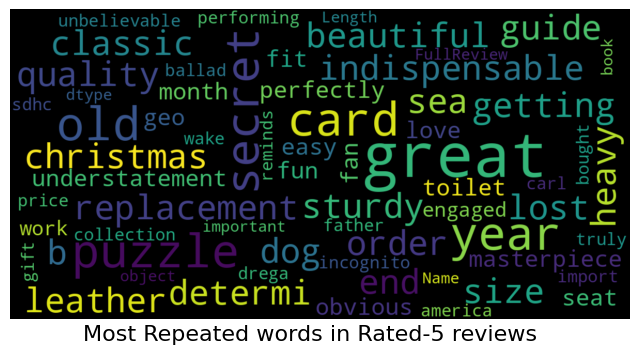

In [ ]:
generate_word_cloud(rating_1, "Most Repeated words in Rated-1 reviews")
generate_word_cloud(rating_2, "Most Repeated words in Rated-2 reviews")
generate_word_cloud(rating_3, "Most Repeated words in Rated-3 reviews")
generate_word_cloud(rating_4, "Most Repeated words in Rated-4 reviews")
generate_word_cloud(rating_5, "Most Repeated words in Rated-5 reviews")

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2),stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]# apply function above

In [ ]:
data_sample.head(1)

,Unnamed: 0,Rating,FullReview
0,1050233,1,recommend styling head tiny missed description...


In [ ]:
from os.path import join

# EDA related imports
from collections import Counter
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

data_sample["FullReview"] = data_sample["FullReview"].apply(str)
# Establishing a function to derive sentiment score from a text
determine_sentiment = lambda content: TextBlob(content).sentiment.polarity

# Introducing an additional column within the dataset
data_sample["sentiment_score"] = data_sample["FullReview"].apply(determine_sentiment)

We investigate the relationship between the sentiment polarity of a review and the rating. We do this by examining how the average sentiment of reviews changes with rating

Average Emotion for Score 1: -0.020072969830683338
Average Emotion for Score 2: 0.0726784265410399
Average Emotion for Score 3: 0.16609991112357397
Average Emotion for Score 4: 0.2678294907685926
Average Emotion for Score 5: 0.34049689681955225


<Axes: xlabel='Rating'>

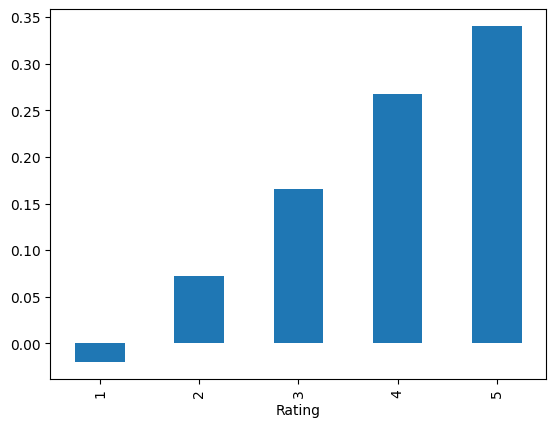

In [ ]:
# Depicting average emotion relative to score
for score in range(1,6):
    print(f"Average Emotion for Score {score}: {data_sample[data_sample['Rating'] == score]['sentiment_score'].mean()}")

data_sample.groupby("Rating")["sentiment_score"].mean().plot(kind="bar")

The mean sentiment of the reviews and the rating are positively correlated. This means that as the mean sentiment of the reviews increases, the rating also tends to increase. We can visualize this relationship using a scatter plot.

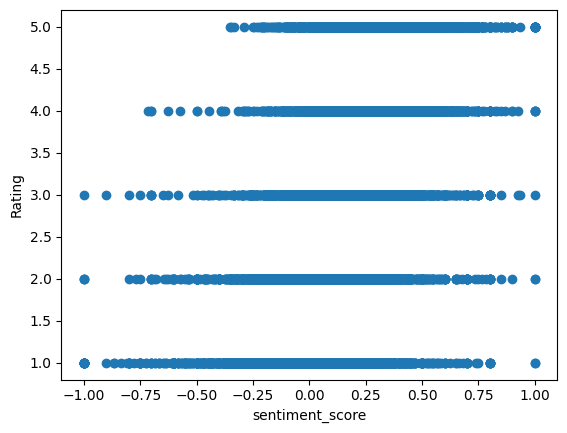

In [ ]:
plt.scatter(data_sample["sentiment_score"], data_sample["Rating"])
plt.xlabel("sentiment_score")
plt.ylabel("Rating")
plt.show()


The mean sentiment of the reviews is positively correlated with the rating, but there is still a lot of variation in the sentiment of individual reviews. This suggests that other factors, such as the specific words used in the review, also play a role in determining the sentiment. We can investigate this further by analyzing the most common words in each review.

In [ ]:
# Function for identifying the top n frequently occurring terms in a sequence
num_top_terms = 30
identify_top_terms = lambda text_sequence, n: Counter(' '.join(text_sequence).split()).most_common(n)
top_terms = data_sample.groupby("Rating")["FullReview"].apply(lambda x: identify_top_terms(x, num_top_terms))

for score in range(1, 6):
    index = score - 1
    print(f"Frequently Occurring Terms for Score {score} organized by sentiment: ")
    # Present the frequently occurring terms for each score, organized by sentiment
    print(list(sorted(top_terms.iloc[index], key=lambda x: TextBlob(x[0]).sentiment.polarity)))
    print("\n")

Frequently Occurring Terms for Score 1 organized by sentiment: 
[('worst', 208), ('bad', 358), ('waste', 295), ('book', 1422), ('like', 727), ('time', 637), ('product', 574), ('movie', 560), ('work', 454), ('buy', 454), ('money', 417), ('read', 412), ('bought', 301), ('year', 286), ('use', 284), ('thing', 278), ('way', 271), ('know', 264), ('people', 262), ('got', 257), ('review', 253), ('amazon', 237), ('want', 232), ('think', 222), ('dvd', 215), ('quality', 210), ('new', 247), ('better', 254), ('good', 499), ('great', 278)]


Frequently Occurring Terms for Score 2 organized by sentiment: 
[('disappointed', 250), ('bad', 300), ('little', 275), ('book', 1752), ('like', 882), ('time', 581), ('movie', 575), ('read', 497), ('work', 406), ('story', 327), ('product', 322), ('year', 320), ('way', 300), ('character', 296), ('use', 295), ('thing', 286), ('buy', 276), ('know', 268), ('think', 263), ('bought', 254), ('got', 247), ('song', 245), ('review', 236), ('album', 234), ('new', 252), ('so

The lower-rated reviews contain many negative words, such as "bad", "waste", and "terrible", while the higher-rated reviews contain many positive words, such as "best" and "excellent". However, some words of the same sentiment, such as "better" and "good", appear in reviews of all ratings.

When the sentiment of a sentence is calculated using TextBlob, as in the above cell, the sentiment is calculated by averaging the sentiments of the individual words in the sentence. However, this approach does not accurately capture the differences in sentiment between two sentences that use similar words but in different contexts.

For example, the sentences "the movie was better than most others" and "the movie could have been much better" both use the word "better", but they have completely different sentiments.

This finding suggests that when conducting sentiment analysis and attempting to predict ratings, we need to use a representation of the review that captures its contextual meaning.

### Topic Modeling

We will use an unsupervised machine learning approach called NMF to identify the main topics in a set of reviews. We will then categorize the reviews into 5 groups based on the topics that they discuss. Finally, we will analyze the relationship between the topics of the reviews and their corresponding ratings.

In [ ]:
def show_selected_words(topic_model, word_list, top_word_count):
    """A utility function for presenting the most significant top_word_count words associated with each topic in a given topic model."""
    for topic_number, topic_terms in enumerate(topic_model.components_):
        print("Topic %d:" % (topic_number))
        print(" ".join([word_list[i]
                          for i in topic_terms.argsort()[:-top_word_count - 1:-1]]))


The training data for the NMF model will be the TF-IDF vectors of each review in the dataset. We limit the number of features (vocabulary size) computed by the TF-IDF vectorizer to reduce redundancy and improve performance.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer with custom parameters
tfidf_processor = TfidfVectorizer(max_df=0.85, min_df=20, max_features=4000, use_idf=True)

# Transform the text data into TF-IDF representation
tfidf_matrix = tfidf_processor.fit_transform(data_sample["FullReview"])

# Retrieve the vocabulary of words used in TF-IDF
tfidf_vocab = tfidf_processor.get_feature_names_out()

# Create a dataframe to display the TF-IDF scores for words in each document
tfidf_document_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=list(tfidf_vocab))
tfidf_document_matrix


,ability,able,absolute,absolutely,academic,accent,accept,acceptable,access,accessory,...,year,yellow,yes,yesterday,yoga,york,young,younger,zero,zombie
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.085101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.098812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.181979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12496,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12497,0.000000,0.122942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.086741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12498,0.135437,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Train the Non-negative Matrix Factorization (NMF) model and derive the most prominent 5 themes
keyword_count = 10
theme_count = 5
nmf_model = NMF(n_components=theme_count, random_state=0, init='nndsvd').fit(tfidf_matrix)
show_selected_words(nmf_model, tfidf_vocab, keyword_count)


Topic 0:
book read story reading character author good page like written
Topic 1:
product work great use good time quality bought price buy
Topic 2:
movie film watch story dvd good bad like acting love
Topic 3:
album song music like sound good band best track fan
Topic 4:
game fun play graphic like playing played old time buy


The first topic appears to be related to positive reviews with high ratings. However, the other topics seem to be more related to the content of the reviews than their overall rating or positivity/negativity. This modeling is not very useful for our task of sentiment analysis, as we are not interested incategorizing the topics of the reviews.

In [ ]:
# Train the Non-negative Matrix Factorization (NMF) model and derive the most prominent 5 themes
keyword_count = 10
theme_count = 10
nmf_model = NMF(n_components=theme_count, random_state=0, init='nndsvd').fit(tfidf_matrix)
show_selected_words(nmf_model, tfidf_vocab, keyword_count)


Topic 0:
book read reading author page written information know want like
Topic 1:
work use time like year bought battery month buy money
Topic 2:
movie watch bad film acting seen like actor watching funny
Topic 3:
album song music like sound band track best fan rock
Topic 4:
game play fun graphic playing played like buy player gameplay
Topic 5:
great love price music toy gift look son old best
Topic 6:
story character read novel interesting plot like series film life
Topic 7:
good pretty quality bad nice better sound overall bit little
Topic 8:
dvd film video season player quality disc episode picture version
Topic 9:
product received amazon item ordered buy recommend quality purchased purchase


In [ ]:
data_sample.head()

,Unnamed: 0,Rating,FullReview,sentiment_score
0,1050233,1,recommend styling head tiny missed description...,-0.039167
1,1109006,1,piece crap piece junk worst design belong frid...,-0.866667
2,2588280,1,weak story line loved file movie waited year s...,-0.126389
3,1897849,1,worthless actual shape wrist rest decent hard ...,-0.231250
4,643177,1,lasted month installed security month quit wor...,0.000000


In [ ]:
data_sample.dtypes

Unnamed: 0           int64
Rating               int64
FullReview          object
sentiment_score    float64
dtype: object

In [ ]:
data_sample.Rating.value_counts()

1    2500
2    2500
3    2500
4    2500
5    2500
Name: Rating, dtype: int64

In [ ]:
df_sample_org = data_sample.copy()

<b> Method1

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [ ]:
data_sample["FullReview"] = data_sample["FullReview"].apply(lambda x: stemming(x))

In [ ]:
print(data_sample["FullReview"].iloc[0],"\n")
data_sample["FullReview"].shape

expected glad actually buy book got library read time wanted stop reading reminds bad soap opera unrealistic center girl suffer anorexia bulimia eating truly eating disorder lot sexual nature imagined hated completely honest want romance novel book truly want understading real people real eating disorder book 



(12500,)

Text(0.5, 1.0, 'Distribution of Ratings')

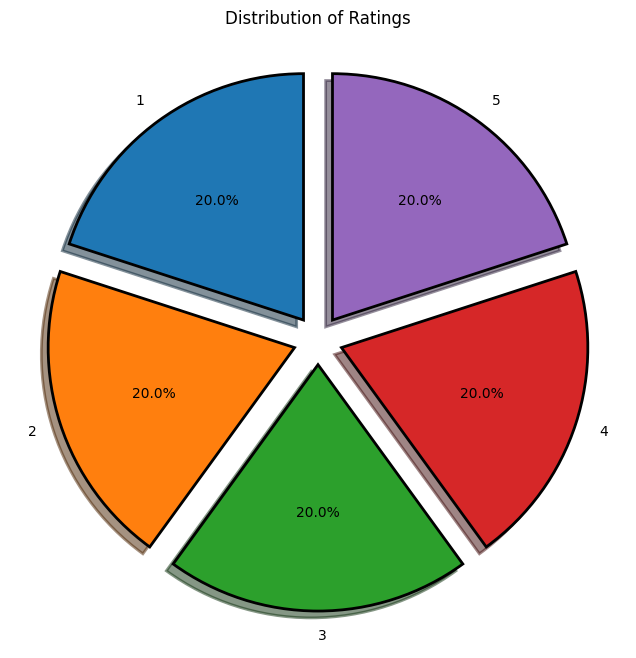

In [ ]:
fig = plt.figure(figsize=(8,8))
wp = {'linewidth':2, 'edgecolor':"black"}
tags = data_sample['Rating'].value_counts()
explode = (0.1,0.1,0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of Ratings')

<b> Vectorizing data using countvectorizer

In [ ]:
vect = CountVectorizer(ngram_range=(1,2)).fit(data_sample["FullReview"])
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 10 features:\n {}".format(feature_names[:10]))

Number of features: 357555

First 10 features:
 ['aa' 'aa confident' 'aa hand' 'aa listening' 'aa release' 'aaa'
 'aaa battery' 'aaa rechargeable' 'aaa size' 'aaaawwwweeessooooommmeeee']


<b> Model deveopment on this data

In [ ]:
data_sample=data_sample.groupby("Rating").sample(500)

In [ ]:
#seperating Independent and Depentent Variables and tranform X data
X = data_sample["FullReview"]
Y = data_sample["Rating"]
X = vect.transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import warnings

# Train and test the models on the original data
models = {
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB()
}

results = {'Model': [],  'Test Accuracy': [], 'Precision': [], 'Recall': []}

for model_name, model in models.items():
    model.fit(X_train.toarray(), y_train)
    # train_pred = model.predict(X_train.toarray())
    test_pred = model.predict(X_test.toarray())

    # train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    precision = precision_score(y_test, test_pred, average = "weighted")
    recall = recall_score(y_test, test_pred, average = "weighted")

    results['Model'].append(model_name)

    results['Test Accuracy'].append(test_acc)
    results['Precision'].append(precision)
    results['Recall'].append(recall)


In [ ]:
pd.DataFrame(results)

,Model,Test Accuracy,Precision,Recall
0,Random Forest,0.368,0.363400,0.368
1,Naive Bayes,0.274,0.263893,0.274


<b> Method-2 using LSTM Models

In [ ]:
data_sample = df_sample_org.copy()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data_sample['FullReview'].values)
X = tokenizer.texts_to_sequences(data_sample['FullReview'].values)
X = pad_sequences(X)

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 78, 128)           256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 78, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 5)                 985       
                                                                 
Total params: 511,785
Trainable params: 511,785
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
Y = pd.get_dummies(data_sample['Rating']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8375, 78) (8375, 5)
(4125, 78) (4125, 5)


In [ ]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)

Epoch 1/7
262/262 - 126s - loss: 1.4854 - accuracy: 0.3187 - 126s/epoch - 479ms/step
Epoch 2/7
262/262 - 100s - loss: 1.2466 - accuracy: 0.4642 - 100s/epoch - 382ms/step
Epoch 3/7
262/262 - 96s - loss: 1.1396 - accuracy: 0.5152 - 96s/epoch - 366ms/step
Epoch 4/7
262/262 - 96s - loss: 1.0493 - accuracy: 0.5666 - 96s/epoch - 368ms/step
Epoch 5/7
262/262 - 97s - loss: 0.9702 - accuracy: 0.6026 - 97s/epoch - 370ms/step
Epoch 6/7
262/262 - 92s - loss: 0.8851 - accuracy: 0.6406 - 92s/epoch - 351ms/step
Epoch 7/7
262/262 - 96s - loss: 0.8219 - accuracy: 0.6704 - 96s/epoch - 366ms/step


In [ ]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

83/83 - 3s - loss: 1.5817 - accuracy: 0.4076 - 3s/epoch - 34ms/step
score: 1.58
acc: 0.41


<b> Using Bert model

In [ ]:
# !pip install tensorflow_text

In [ ]:
import tensorflow as tf
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus_available)
assert num_gpus_available > 0
!pip install transformers
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
import pandas as pd
import numpy as np

Num GPUs Available:  1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.6 MB/s eta 0:00:00


In [ ]:
data_sample = data_org.copy()

In [ ]:
data_sample = data_sample[["FullReview", "Rating"]].copy()

In [ ]:
data_sample.head()

,FullReview,Rating
0,piece garbage year purchase awful product over...,1
1,replacement ink cartridge bought fly pentop da...,1
2,amazon need remove selection plot acting minut...,1
3,called breaking child heart start good idea mi...,1
4,written offensive actually agree reviewer writ...,1


In [ ]:
reviews = data_sample['FullReview'].values.tolist()
labels = data_sample['Rating'].tolist()

In [ ]:
reviews[0:5], labels[0:5]

(['piece garbage year purchase awful product overheated melted steel prong ash melting plastic temperature control unit essentially destroying product easily caused hadn watching noticed grill wasn cooking properly power melt steel plastic connection buyer beware total hazard piece poorly built garbage star',
  'replacement ink cartridge bought fly pentop daughter use won write searching internet customer service number come help',
  'amazon need remove selection plot acting minute bad barely story amazon delete qualifies garbage minute mistake ordering hit',
  'called breaking child heart start good idea misinterprets scripture saying hit spank child order obey god advocate hitting infant waaaay young understand hit say repeat spanking child show negative emotion spanking sound christian early childhood professional devout christian recommend book parent church plenty biblically accurate child rearing book jesus raise child teresa whitehurst biblical parenting crystal lutton thy rod t

In [ ]:
from sklearn.model_selection import train_test_split
training_sentences, validation_sentences, training_labels, validation_labels = train_test_split(reviews, labels, test_size=.2)

In [ ]:
#Assign tokenizer object to the tokenizer class
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer([training_sentences[0]], truncation=True, padding=True, max_length=128)

{'input_ids': [[101, 2189, 14301, 2121, 4149, 2905, 5798, 2556, 7537, 3435, 4031, 12057, 5466, 5963, 2201, 5580, 2583, 2905, 7078, 3866, 4283, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
train_encodings = tokenizer(training_sentences,
                            truncation=True,
                            padding=True)
val_encodings = tokenizer(validation_sentences,
                            truncation=True,
                            padding=True)
train_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(train_encodings),
                            training_labels
                            ))
val_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(val_encodings),
                            validation_labels
                            ))

In [ ]:
train_dataset

<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(242,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(242,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=5)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
model.fit(train_dataset.shuffle(100).batch(16),
          epochs=2,
          batch_size=16,
          validation_data=val_dataset.shuffle(100).batch(16))

Epoch 1/2
625/625 [==============================] - 299s 429ms/step - loss: nan - accuracy: 4.0000e-04 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/2
625/625 [==============================] - 249s 399ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00


In [ ]:
model.save_pretrained("./sentiment")
loaded_model = TFDistilBertForSequenceClassification.from_pretrained("./sentiment")

Some layers from the model checkpoint at ./sentiment were not used when initializing TFDistilBertForSequenceClassification: ['dropout_59']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./sentiment and are newly initialized: ['dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
test_sentence = "This is a really bad product. I hate it"
predict_input = tokenizer.encode(test_sentence,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")
tf_output = loaded_model.predict(predict_input)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)
labels = [0,1,2,3,4]
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
print(labels[label[0]])

1/1 [==============================] - 0s 90ms/step
0
